In [7]:
# 1. traditional backwards feature selection: take a feature out, retrain model without feature and see how performance changed. features who droppage least affects the
# model performance have love impact on predictive performance and should be permanently dropped
# 2. sensitivity analysis +backwards elimination feature selection. measuring how variance in each feature affects the output. THis method has different variants depending on the exact model
# (look into partial dependence plots)

In [8]:
%pip install ucimlrepo

###Loading the data set

In [9]:
from ucimlrepo import fetch_ucirepo
from ucimlrepo import list_available_datasets


# fetch dataset
wine_quality = fetch_ucirepo(id=186)


# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets



#X.head()
#y.head()
# variable information
#print(wine_quality.variables)

X.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


###Data Preprocessing: want to understand how the data is distributed and perfoming cleaning if necesary

In [10]:
# histogram to give an idea of how imbalanced the quality is
#from matplotlib import pyplot as plt
#import seaborn as sns

'''ax = y.value_counts().plot(kind='bar', title='Distribution of Quality Classes')

# Add labels to each bar
for container in ax.containers:
    ax.bar_label(container)

ax.set_xlabel('Quality Class')
ax.set_ylabel('Count')'''

y.value_counts().index

MultiIndex([(6,),
            (5,),
            (7,),
            (4,),
            (8,),
            (3,),
            (9,)],
           names=['quality'])

In [11]:
#X.describe()

#Model A (without sampling)



In [12]:
!pip install imbalanced-learn

###Split the data

In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd

y_flat = y.values.ravel()
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

best_models = []

###Check for imbalance in the training/test split

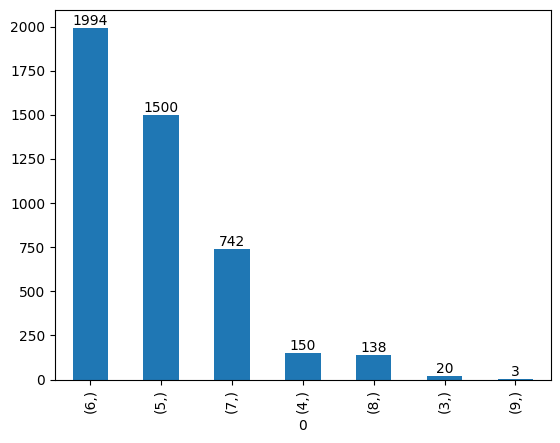

In [14]:
ax = (pd.DataFrame(y_train)).value_counts().plot(kind='bar')
#ax = (pd.DataFrame(y_test)).value_counts().plot(kind='bar')

# Add labels to each bar
for container in ax.containers:
    ax.bar_label(container)

###I think its natural to have more normal wines that excellent ones so I would model with and without imbalance handling

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


###Modeling without class weighting

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np

l1_log_model_A = LogisticRegression(penalty='l1', solver='saga', random_state=17, max_iter=10000) # logistic reg with l1 regularization
l2_log_model_A = LogisticRegression(penalty='l2', solver='saga', random_state=17,max_iter=10000) # logistic reg with l2 regularization

#training models
l1_log_model_A.fit(X_train,y_train)
l2_log_model_A.fit(X_train,y_train)

#computing predictions
l1_y_pred = l1_log_model_A.predict(X_val)
l2_y_pred = l2_log_model_A.predict(X_val)

# Store predictions in a dictionary
predictions = {'L1': l1_y_pred, 'L2': l2_y_pred}

log_reg_results = []

# Compute metrics and store them
for key, y_pred in predictions.items():
    metrics = {
        'Type': 'Non_FS',
        'Model': f'Logistic Regression ({key})',
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, average='macro', zero_division=np.nan),
        'recall': recall_score(y_val, y_pred, average='macro'),
        'f1': f1_score(y_val, y_pred, average='macro'),
    }

    log_reg_results.append(metrics)


log_reg_results_df = pd.DataFrame(log_reg_results)

# sort by accuracy
log_reg_results_df.sort_values(by = 'accuracy', ascending= False, inplace=True)
log_reg_results_df.reset_index(drop=True, inplace=True)


# I inspected the result dataframe and found that the first value was the best
best_log_reg = log_reg_results_df.iloc[0].to_dict()
best_models.append(best_log_reg)#add the best model to the list

print(f'Best log_reg_ Model {best_log_reg}')



'''for key, y_pred in predictions.items():
    metrics = {
       'Type': 'Non_FS',
        'Model': f'Logistic Regression ({key})',
        'accuracy': accuracy_score(y_val, y_pred),
        'precision_macro': precision_score(y_val, y_pred, average='macro', zero_division=np.nan),
        'recall_macro': recall_score(y_val, y_pred, average='macro'),
        'f1_macro': f1_score(y_val, y_pred, average='macro'),
        'precision_weighted': precision_score(y_val, y_pred, average='weighted', zero_division=np.nan),
        'recall_weighted': recall_score(y_val, y_pred, average='weighted'),
        'f1_weighted': f1_score(y_val, y_pred, average='weighted')
    }
    log_reg_results.append(metrics)'''

log_reg_results_df.head()



Best log_reg_ Model {'Type': 'Non_FS', 'Model': 'Logistic Regression (L1)', 'accuracy': 0.5435897435897435, 'precision': 0.5112703176600941, 'recall': 0.21832939253406644, 'f1': 0.2162723212802}


,Type,Model,accuracy,precision,recall,f1
0,Non_FS,Logistic Regression (L1),0.54359,0.511270,0.218329,0.216272
1,Non_FS,Logistic Regression (L2),0.54359,0.510395,0.218329,0.216251


In [17]:
f = pd.DataFrame(l1_log_model_A.coef_)

f

,0,1,2,3,4,5,6,7,8,9,10
0,0.645406,0.524013,0.000000,0.000000,0.420327,0.000000,0.396398,0.039227,0.398675,-1.073721,-0.327275
1,-0.165716,0.480841,0.000000,-0.437676,0.000000,-1.334306,0.698820,0.000000,-0.193700,0.000000,-0.988745
2,-0.490858,0.114334,0.050846,-0.962135,0.117355,-0.256824,0.320434,1.041541,-0.373494,-0.082554,-0.926986
3,-0.438070,-0.505390,-0.020750,-0.699939,0.060553,-0.029152,0.000000,0.968500,-0.305632,0.187448,0.000000
4,0.121352,-0.810236,-0.058940,0.102966,-0.056218,0.049179,-0.208515,-0.037578,0.040944,0.468725,0.389189
5,0.000000,-0.890525,0.000000,0.260251,0.000000,0.280652,-0.105052,-0.026487,0.000000,0.318883,0.613676
6,0.752681,0.000000,0.000000,0.000000,-2.186242,0.000000,0.000000,0.000000,0.537200,0.000000,0.008370


##Modeling with class weighting

In [18]:
l1_log_model_A = LogisticRegression(penalty='l1',class_weight='balanced', solver='saga', random_state=17) # logistic reg with l1 regularization and weighted classes
l2_log_model_A = LogisticRegression(penalty='l2',class_weight='balanced', solver='saga', random_state=17) # logistic reg with l2 regularization and weighted classes

#training models
l1_log_model_A.fit(X_train,y_train)
l2_log_model_A.fit(X_train,y_train)

#compiting predictions
l1_y_pred = l1_log_model_A.predict(X_val)
l2_y_pred = l2_log_model_A.predict(X_val)

# Store predictions in a dictionary
predictions = {'wL1': l1_y_pred, 'wL2': l2_y_pred}

log_reg_results = []

# Compute metrics and store them
for key, y_pred in predictions.items():
    metrics = {
        'Type': 'Non_FS',
        'Model': f'Logistic Regression ({key})',
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, average='macro', zero_division=np.nan),
        'recall': recall_score(y_val, y_pred, average='macro'),
        'f1': f1_score(y_val, y_pred, average='macro'),
    }

    log_reg_results.append(metrics)


log_reg_results_df = pd.DataFrame(log_reg_results)

# sort by accuracy
log_reg_results_df.sort_values(by = 'accuracy', ascending= False, inplace=True)
log_reg_results_df.reset_index(drop=True, inplace=True)


# I inspected the result dataframe and found that the first value was the best
best_log_reg = log_reg_results_df.iloc[0].to_dict()
best_models.append(best_log_reg)#add the best model to the list

print(f'Best log_reg_ Model {best_log_reg}')

log_reg_results_df.head()



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best log_reg_ Model {'Type': 'Non_FS', 'Model': 'Logistic Regression (wL2)', 'accuracy': 0.28, 'precision': 0.23152076491172718, 'recall': 0.43151222471002154, 'f1': 0.1961793804290066}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,Type,Model,accuracy,precision,recall,f1
0,Non_FS,Logistic Regression (wL2),0.280000,0.231521,0.431512,0.196179
1,Non_FS,Logistic Regression (wL1),0.270769,0.234039,0.270533,0.187279


In [19]:
f = pd.DataFrame(l1_log_model_A.coef_)

f

,0,1,2,3,4,5,6,7,8,9,10
0,0.322656,0.577828,0.000805,0.245736,2.430955,-0.370823,0.451266,0.181804,0.195064,-1.691970,-0.059807
1,-1.399180,0.424990,-0.027007,-1.086429,1.516110,-0.816629,0.192521,0.408876,-0.797580,-0.016858,-0.452346
2,-1.263311,0.222053,-0.016737,-1.123190,1.624200,0.016672,0.081077,1.098814,-0.777487,-0.160074,-0.343982
3,-1.258269,-0.431452,-0.117045,-1.068540,1.763153,0.222256,-0.180859,1.401378,-0.803009,0.041723,0.622081
4,-0.832475,-0.862067,-0.218514,-0.481575,1.705811,0.183570,-0.260287,0.734628,-0.622238,0.276517,1.096387
5,-1.203564,-0.992147,-0.030645,-0.259751,1.749822,0.126186,-0.134014,0.755506,-0.630063,0.194387,1.295180
6,7.491944,0.691932,0.571522,5.661386,-13.208519,0.361952,-0.242936,-6.562824,5.021510,0.636977,-2.109607


#Modeling with SMOTE

In [20]:
#We are resplitting the data because we have already performing scaling in the experiments above
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

In [21]:
# counting the number of classes in train
#from collections import Counter
#print (Counter(y_train))

In [22]:
#handling imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=17,k_neighbors=2)
# prefixing with s to indicate smote
sX_train, sy_train = smote.fit_resample(X_train, y_train)

In [23]:
# scaling
scaler = StandardScaler()
sX_train = scaler.fit_transform(sX_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [24]:
#modeling
sl1_log_model_A = LogisticRegression(penalty='l1', solver='saga', random_state=17) # logistic reg with l1 regularization
sl2_log_model_A = LogisticRegression(penalty='l2', solver='saga', random_state=17) # logistic reg with l2 regularization

#training models
sl1_log_model_A.fit(sX_train,sy_train)
sl2_log_model_A.fit(sX_train,sy_train)

#compiting predictions
sl1_y_pred = sl1_log_model_A.predict(X_val)
sl2_y_pred = sl2_log_model_A.predict(X_val)

# Store predictions in a dictionary
predictions = {'sL1': sl1_y_pred, 'sL2': sl2_y_pred}

log_reg_results = []

# Compute metrics and store them
for key, y_pred in predictions.items():
    metrics = {
        'Type': 'Non_FS',
        'Model': f'Logistic Regression ({key})',
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, average='macro', zero_division=np.nan),
        'recall': recall_score(y_val, y_pred, average='macro'),
        'f1': f1_score(y_val, y_pred, average='macro'),
    }

    log_reg_results.append(metrics)


log_reg_results_df = pd.DataFrame(log_reg_results)

# sort by accuracy
log_reg_results_df.sort_values(by = 'accuracy', ascending= False, inplace=True)
log_reg_results_df.reset_index(drop=True, inplace=True)


# I inspected the result dataframe and found that the first value was the best
best_log_reg = log_reg_results_df.iloc[0].to_dict()
best_models.append(best_log_reg)#add the best model to the list

print(f'Best log_reg_ Model {best_log_reg}')

log_reg_results_df.head()

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best log_reg_ Model {'Type': 'Non_FS', 'Model': 'Logistic Regression (sL1)', 'accuracy': 0.30153846153846153, 'precision': 0.23637007754414535, 'recall': 0.27682190633262643, 'f1': 0.1983111922696215}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,Type,Model,accuracy,precision,recall,f1
0,Non_FS,Logistic Regression (sL1),0.301538,0.236370,0.276822,0.198311
1,Non_FS,Logistic Regression (sL2),0.300513,0.235673,0.276486,0.197843


#Modeling with Random Undersampling


In [25]:
#We are resplitting the data because we have already performing smote and scaling  on the data in the experiments above
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

In [26]:
# handling undersampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=17)
# prefixing with r to indicate random undersampling
rX_train, ry_train = ros.fit_resample(X_train, y_train)

In [27]:
# scaling
scaler = StandardScaler()
rX_train = scaler.fit_transform(rX_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [28]:
#modeling
rl1_log_model_A = LogisticRegression(penalty='l1', solver='saga', random_state=17) # logistic reg with l1 regularization
rl2_log_model_A = LogisticRegression(penalty='l2', solver='saga', random_state=17) # logistic reg with l2 regularization

#training models
rl1_log_model_A.fit(rX_train,ry_train)
rl2_log_model_A.fit(rX_train,ry_train)

#compiting predictions
rl1_y_pred = rl1_log_model_A.predict(X_val)
rl2_y_pred = rl2_log_model_A.predict(X_val)

# Store predictions in a dictionary
predictions = {'rL1': rl1_y_pred, 'rL2': rl2_y_pred}

log_reg_results = []

# Compute metrics and store them
for key, y_pred in predictions.items():
    metrics = {
        'Type': 'Non_FS',
        'Model': f'Logistic Regression ({key})',
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, average='macro', zero_division=np.nan),
        'recall': recall_score(y_val, y_pred, average='macro'),
        'f1': f1_score(y_val, y_pred, average='macro'),
    }

    log_reg_results.append(metrics)


log_reg_results_df = pd.DataFrame(log_reg_results)

# sort by accuracy
log_reg_results_df.sort_values(by = 'accuracy', ascending= False, inplace=True)
log_reg_results_df.reset_index(drop=True, inplace=True)


# I inspected the result dataframe and found that the first value was the best
best_log_reg = log_reg_results_df.iloc[0].to_dict()
best_models.append(best_log_reg)#add the best model to the list

print(f'Best log_reg_ Model {best_log_reg}')

log_reg_results_df.head()

Best log_reg_ Model {'Type': 'Non_FS', 'Model': 'Logistic Regression (rL1)', 'accuracy': 0.27282051282051284, 'precision': 0.2084486497458986, 'recall': 0.20023448976761493, 'f1': 0.16996654996481983}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,Type,Model,accuracy,precision,recall,f1
0,Non_FS,Logistic Regression (rL1),0.272821,0.208449,0.200234,0.169967
1,Non_FS,Logistic Regression (rL2),0.241026,0.199043,0.185815,0.158305


In [29]:
#print (rl2_log_model_A.coef_)

f = pd.DataFrame(rl2_log_model_A.coef_)

f

,0,1,2,3,4,5,6,7,8,9,10
0,-0.351904,0.734412,-0.475759,0.186371,0.283658,0.306971,0.706708,0.599818,0.508938,0.205393,-0.480028
1,-0.126737,0.557191,0.064639,0.273662,-0.242920,-0.156506,-0.649040,0.278886,-0.414115,-0.176062,-0.074514
2,-0.150978,-0.059135,-0.173968,-0.543297,0.798819,-0.518644,0.152717,0.142877,-0.355581,0.102592,-0.816673
3,0.427789,-0.766042,0.239450,-0.755746,-0.100161,-0.165159,0.194518,-0.319746,-0.226780,0.432377,0.241981
4,-0.032027,-0.133457,-0.038844,0.212636,0.104379,0.171979,-0.029990,-0.049825,-0.526670,-0.073660,0.400838
5,-0.683035,-0.524819,0.057565,0.571912,-0.164142,0.058474,-0.110885,-0.279727,0.489174,-0.543151,0.321741
6,0.916893,0.191851,0.326916,0.054462,-0.679634,0.302885,-0.264028,-0.372283,0.525035,0.052512,0.406655


#Choosing a the best model for feature selection



In [30]:
#analyzing the top models in every experiment above to pick the best one
best_models_df = pd.DataFrame(best_models)
#best_models_df.drop( columns=['Type', 'accuracy', 'precision', 'recall', 'f1'], inplace=True)

chosen_one = best_models_df.iloc[0].to_dict()

print(chosen_one)

#we deduce the necesary parameters from the best model and reassign chosen one to the parameter list

chosen_one = {
    'penalty':'l1',
    'solver':'saga',
    'random_state':17,
    'max_iter':10000}

best_models_df

#print(chosen_one)

{'Type': 'Non_FS', 'Model': 'Logistic Regression (L1)', 'accuracy': 0.5435897435897435, 'precision': 0.5112703176600941, 'recall': 0.21832939253406644, 'f1': 0.2162723212802}


,Type,Model,accuracy,precision,recall,f1
0,Non_FS,Logistic Regression (L1),0.543590,0.511270,0.218329,0.216272
1,Non_FS,Logistic Regression (wL2),0.280000,0.231521,0.431512,0.196179
2,Non_FS,Logistic Regression (sL1),0.301538,0.236370,0.276822,0.198311
3,Non_FS,Logistic Regression (rL1),0.272821,0.208449,0.200234,0.169967


#Feature Selection

In [31]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold


#resplitting the data
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

# have t make sure we feed the same data structures to the model
'''y_test = pd.DataFrame(y_test)
y_train = pd.DataFrame(y_train)
y_val =   pd.DataFrame(y_val)'''

#rescaling
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_val = pd.DataFrame(scaler.transform(X_val),columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X.columns)

#declaring the chosen estimator and passing in best parameters
estimator = LogisticRegression(**chosen_one)

sfs = SequentialFeatureSelector(
    estimator=estimator,
    direction='backward',
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3), #ensuring that each fold maintains the same proportion of classes as the original dataset
    n_jobs=-1
)

sfs.fit(X_train, y_train)

selected_features = X.columns[sfs.get_support()]


FS_X_train = X_train[selected_features]
FS_X_val = X_val[selected_features]
FS_X_test = X_test[selected_features]
print('Selected features: ', selected_features )



Selected features:  Index(['volatile_acidity', 'residual_sugar', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'pH', 'alcohol'],
      dtype='object')


# Fitting Final Model and Performing Evaluation

In [32]:
estimator.fit(FS_X_train, y_train)

# make predictions on test
y_test_pred = estimator.predict(FS_X_test)

# compute metrics for test
accuracy = accuracy_score(y_test, y_test_pred)
macro_precision = precision_score(y_test, y_test_pred, average='macro',zero_division=np.nan)
macro_recall = recall_score(y_test, y_test_pred, average='macro')
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
weighted_precision = precision_score(y_test, y_test_pred, average='weighted',zero_division=np.nan)
weighted_recall = recall_score(y_test, y_test_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')


eval_stats = {'Type': 'Logistic Regression',
      'accuracy' : accuracy,
      'macro_precision' : macro_precision,
      'weighted_precision' : weighted_precision,
      'macro_recall' : macro_recall,
      'weighted_recall' : weighted_recall,
      'macro_f1' : macro_f1,
      'weighted_f1' : weighted_f1,
      'penalty': estimator.get_params()['penalty'],
      'solver':estimator.get_params()['solver'],
      'max_iter':estimator.get_params()['max_iter']
}


print (eval_stats)

{'Type': 'Logistic Regression', 'accuracy': 0.5323076923076923, 'macro_precision': 0.5205962173002313, 'weighted_precision': 0.5284732886593141, 'macro_recall': 0.21456924115426101, 'weighted_recall': 0.5323076923076923, 'macro_f1': 0.20927667240116024, 'weighted_f1': 0.497096738934753, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 10000}


LR Normalized confusion matrix
[[0.   0.   0.75 0.25 0.   0.   0.  ]
 [0.   0.   0.7  0.3  0.   0.   0.  ]
 [0.   0.   0.59 0.4  0.01 0.   0.  ]
 [0.   0.   0.22 0.71 0.07 0.   0.  ]
 [0.   0.   0.07 0.72 0.2  0.   0.  ]
 [0.   0.   0.04 0.64 0.32 0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]]


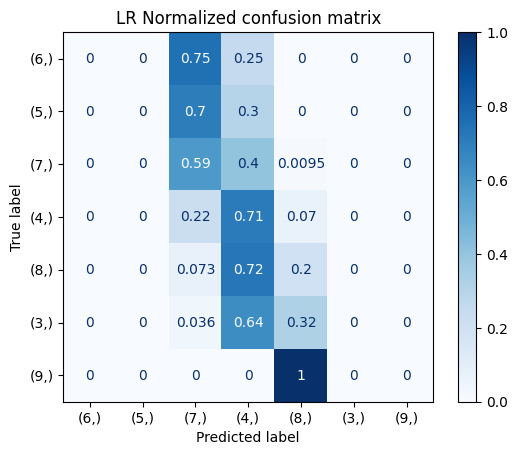

In [36]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


class_names = y.value_counts().index

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    #(" LR Confusion matrix, without normalization", None),
    ("LR Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
       estimator,
       FS_X_test,
       y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()